# TP1 – Analyse des données (IFT599 / IFT799)

**Auteurs :**  
-  
-  
-  3

**Date de remise :** 03 octobre 2025  


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Charger tous les jeux de données

In [2]:
# Load transaction data
transactions = pd.read_csv("data/transactions_data.csv")

# Load card information
cards = pd.read_csv("data/cards_data.csv")

# Load user information
users = pd.read_csv("data/users_data.csv")

# Load mcc codes information
with open("data/mcc_codes.json", "r") as f:
    mcc_data = json.load(f)

mcc_codes = pd.DataFrame(list(mcc_data.items()), columns=["code", "description"])

# Load fraud information
with open("data/train_fraud_labels.json", "r") as f:
    fraud_data = json.load(f)

# Extract the inner dictionary
fraud_dict = fraud_data['target']

# Convert to DataFrame
fraud_labels = pd.DataFrame(list(fraud_dict.items()), columns=["transaction_id", "is_fraud"])

# 3.1 Préparation des données (25%)

## 1. Fusion des différents fichiers (`transactions`, `cards`, `users`, `mcc`, `fraud`)  
  - Clés de jointure utilisées  
  - Vérifier lees colonnes dupliquées et suffixes `_x`, `_y`  (causés par pandas)
  - Expliquer les choix 

In [3]:
# Rename keys before merging
transactions = transactions.rename(columns={"id": "transaction_id"})
cards = cards.rename(columns={"id": "card_id"})
users = users.rename(columns={"id": "user_id"})
mcc_codes = mcc_codes.rename(columns={"code": "mcc_code", "description": "mcc_description"})

In [4]:
# Ensure same dtype for transaction_id
transactions["transaction_id"] = transactions["transaction_id"].astype(str)
fraud_labels["transaction_id"] = fraud_labels["transaction_id"].astype(str)

# Ensure same dtype for mcc
transactions["mcc"] = transactions["mcc"].astype(str)
mcc_codes["mcc_code"] = mcc_codes["mcc_code"].astype(str)

In [5]:
merged_df = (
    transactions
    .merge(cards, on="card_id", how="left", suffixes=("", "_card"))
    .merge(users, left_on="client_id", right_on="user_id", how="left", suffixes=("", "_user"))
    .merge(mcc_codes, left_on="mcc", right_on="mcc_code", how="left")
    .merge(fraud_labels, on="transaction_id", how="left")
)

merged_df.head()

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,mcc_code,mcc_description,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,46.80,-100.76,$23679,$48277,$110153,740,4,5499,Miscellaneous Food Stores,No
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,40.80,-91.12,$18076,$36853,$112139,834,5,5311,Department Stores,No
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,33.18,-117.29,$16894,$34449,$36540,686,3,4829,Money Transfer,No
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,...,41.42,-87.35,$26168,$53350,$128676,685,5,4829,Money Transfer,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,38.86,-76.60,$33529,$68362,$96182,711,2,5813,Drinking Places (Alcoholic Beverages),No


## 2. Identification des variables peu pertinentes  
  - Liste des variables exclues  
  - Justifications (faible variance, redondance, trop de valeurs manquantes, etc.)(liste dans le pdf)  
  - Visualisations ou statistiques descriptives à l’appui  (généralement boxplot)

In [6]:
# List columns
print(merged_df.columns.tolist())

['transaction_id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors', 'client_id_card', 'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web', 'user_id', 'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender', 'address', 'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'mcc_code', 'mcc_description', 'is_fraud']


**2.1 Low variance and redundancy** 

Look at the variance of numerical variables and the number of unique values for categorical variables to identify potential candidates for exclusion.

**Findings:**

- Unique identifiers (no behavioral meaning): `transaction_id`, `card_id`, `user_id`, `client_id_card`, `card_number`

These are purely technical IDs, unique per row or per client, and do not provide useful information for behavioral or fraud analysis.

- Low analytical value: `cvv`, `retirement_age`

CVV codes are static per card and not indicative of transaction patterns or fraud behaviors.

Retirement age shows little relevance to transaction behavior.

- Redundant variables: `current_age`, `birth_year`, `zip`, `latitude`, `longitude`

Keep `current_age`, drop `birth_year`, they hold the same information, just encoded differently.

To reduce dimensionality, keep `zip` and drop `latitude`, `longitude`.

In [7]:
# Check variance for numeric features
low_variance = merged_df.var(numeric_only=True).sort_values()
print(low_variance)

# Look at categorical features' unique values
for col in merged_df.select_dtypes(include=['object']).columns:
    print(col, merged_df[col].nunique())

num_cards_issued         2.654476e-01
num_credit_cards         2.458112e+00
year_pin_last_changed    8.379903e+00
retirement_age           1.286465e+01
birth_month              1.299606e+01
latitude                 2.592665e+01
birth_year               2.470101e+02
current_age              2.473543e+02
longitude                2.644312e+02
credit_score             4.329996e+03
cvv                      8.327915e+04
client_id_card           3.383034e+05
user_id                  3.383034e+05
client_id                3.383034e+05
card_id                  2.803468e+06
merchant_id              6.664317e+08
zip                      8.646085e+08
card_number              1.720131e+30
dtype: float64
transaction_id 13305915
date 4136496
amount 81161
use_chip 3
merchant_city 12492
merchant_state 199
mcc 109
errors 22
card_brand 4
card_type 3
expires 180
has_chip 2
credit_limit 2603
acct_open_date 295
card_on_dark_web 1
gender 2
address 1219
per_capita_income 1120
yearly_income 1201
total_debt 1150

In [8]:
# IDs / unique identifiers and irrelevant columns
drop_id_cols = [ "transaction_id", "card_id", "user_id", "client_id_card", "card_number", "cvv"]

**2.2 Correlation**

Compute a correlation matrix and display a heatmap to identify highly correlated or redundant variables.

**Findings:**

- `current_age` is highly correlated with `birth_year` → keep `current_age`, drop `birth_year`.

- `client_id`, `client_id_card`, and `user_id` are perfectly correlated → keep `client_id`, drop the rest.

- `longitude` shows high correlation with `zip`, while `latitude` shows moderate correlation → choose one representation.

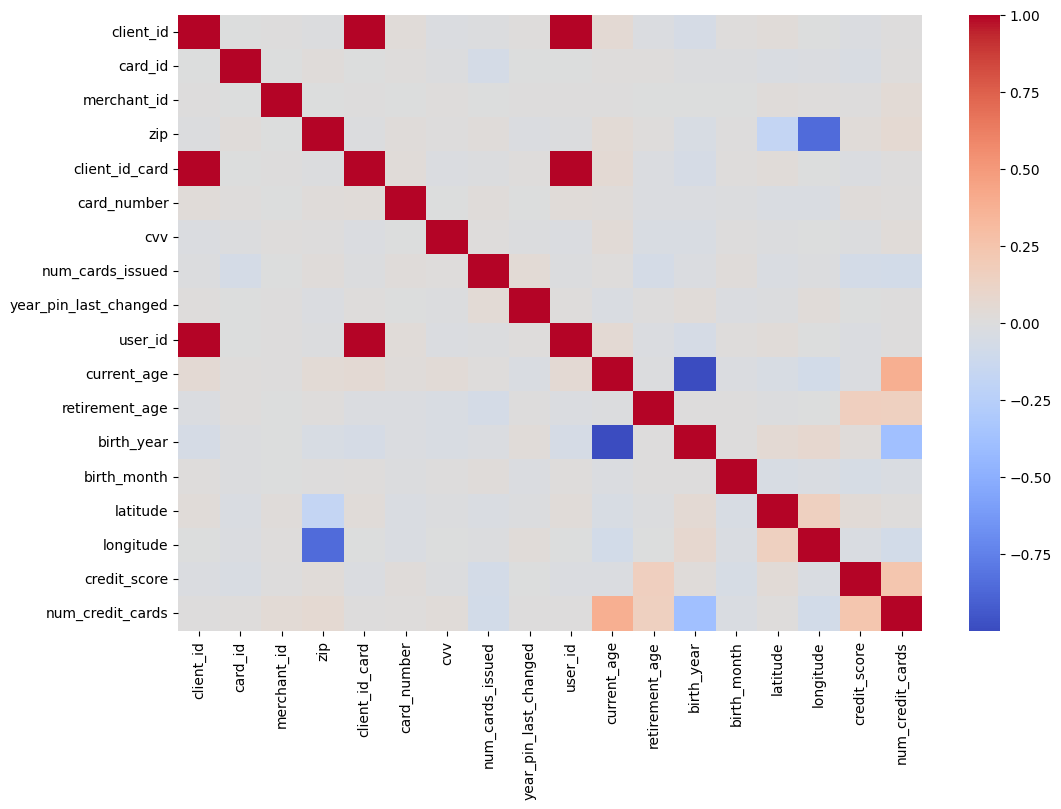

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = merged_df.corr(numeric_only=True)

# Plot a heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.show()

In [10]:
# Highly correlated variables
drop_correlated_cols = [ "retirement_age", "birth_year", "latitude", "longitude"]

**2.3 Missing values**

Identify variables with a high proportion of missing values that provide little usable information. These variables will be found during data cleaning.

**Findings:**

- `errors` contains 98% missing values → drop it.

In [11]:
# Columns with too many missing values 
drop_missing_cols = ["errors"]

# Combine all into one list
cols_to_drop = drop_id_cols + drop_correlated_cols + drop_missing_cols

## 3. Nettoyage des données
  
- Valeurs manquantes  
- Doublons  
- Types de données  
- Incohérences
- Transactions dupliquées

**Valeurs manquantes**

errors                   0.984113
is_fraud                 0.330000
zip                      0.124208
merchant_state           0.117519
mcc_description          0.000000
latitude                 0.000000
user_id                  0.000000
current_age              0.000000
retirement_age           0.000000
birth_year               0.000000
birth_month              0.000000
gender                   0.000000
address                  0.000000
longitude                0.000000
mcc_code                 0.000000
year_pin_last_changed    0.000000
per_capita_income        0.000000
yearly_income            0.000000
total_debt               0.000000
credit_score             0.000000
num_credit_cards         0.000000
card_on_dark_web         0.000000
transaction_id           0.000000
acct_open_date           0.000000
date                     0.000000
client_id                0.000000
card_id                  0.000000
amount                   0.000000
use_chip                 0.000000
merchant_id   

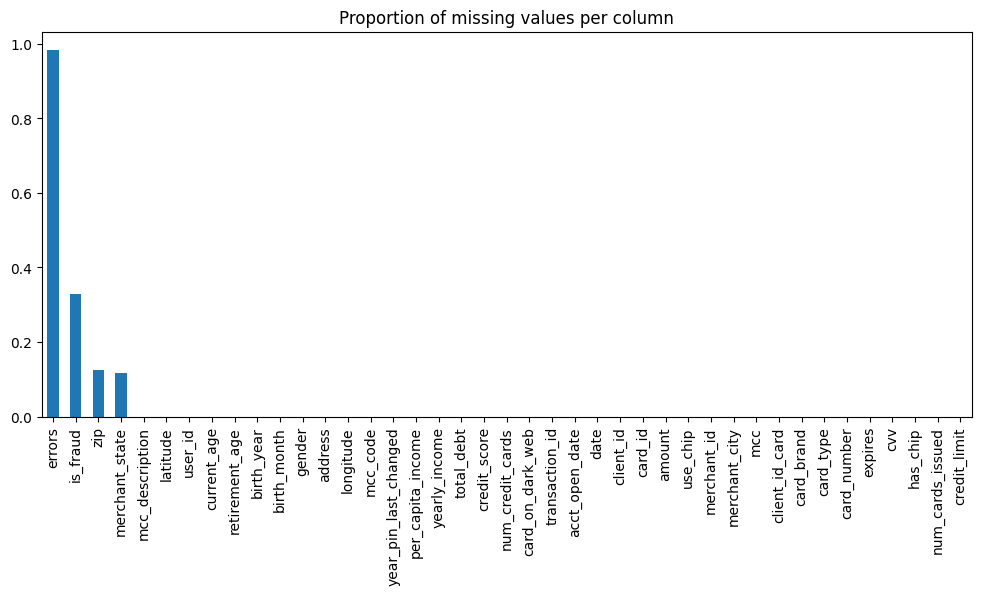

In [12]:
# Check missing values
missing = merged_df.isnull().mean().sort_values(ascending=False)
print(missing)

# Visualize
missing.plot(kind="bar", figsize=(12,5), title="Proportion of missing values per column")
plt.show()

**Doublons**

In [13]:
# Count fully duplicated rows
dup_rows = merged_df.duplicated().sum()
print(f"Number of completely duplicated rows: {dup_rows}")

# If you find any, drop them
merged_df = merged_df.drop_duplicates()

Number of completely duplicated rows: 0


In [14]:
# Check if any transaction_id is duplicated
dup_trans = merged_df["transaction_id"].duplicated().sum()
print(f"Number of duplicated transaction_id: {dup_trans}")

# If you find any, keep only the first occurrence
merged_df = merged_df.drop_duplicates(subset=["transaction_id"], keep="first")

Number of duplicated transaction_id: 0


In [15]:
# How many unique transactions per card_id / client_id?
print(merged_df.groupby("card_id")["transaction_id"].nunique().head())
print(merged_df.groupby("client_id")["transaction_id"].nunique().head())

card_id
0    3402
1    2841
2    8028
3    2870
4     890
Name: transaction_id, dtype: int64
client_id
0    12795
1    10073
2    10612
3     6001
4    15043
Name: transaction_id, dtype: int64


**Types de données**
- Transaction amounts: Remove `$`, convert to float, then check stats.

In [16]:
# List of columns that contain dollar amounts
money_cols = ["amount", "per_capita_income", "yearly_income", "total_debt"]

# Remove $ and commas, convert to float
for col in money_cols:
    merged_df[col] = (merged_df[col].replace('[\$,]', '', regex=True).astype(float))


In [17]:
merged_df.head()

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,mcc_code,mcc_description,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,46.80,-100.76,23679.0,48277.0,110153.0,740,4,5499,Miscellaneous Food Stores,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,40.80,-91.12,18076.0,36853.0,112139.0,834,5,5311,Department Stores,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,33.18,-117.29,16894.0,34449.0,36540.0,686,3,4829,Money Transfer,No
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,...,41.42,-87.35,26168.0,53350.0,128676.0,685,5,4829,Money Transfer,NaN
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,38.86,-76.60,33529.0,68362.0,96182.0,711,2,5813,Drinking Places (Alcoholic Beverages),No


- Date format: Convert to datetime and check ordering.

In [18]:
merged_df["date"] = pd.to_datetime(merged_df["date"], errors="coerce")

# Check if any failed conversion (become NaT)
print("Invalid dates:", merged_df["date"].isna().sum())

Invalid dates: 0


In [19]:
# Check typos or inconsistent formatting.
print("Unique use_chip values:", merged_df["use_chip"].unique())
print("Unique fraud labels:", merged_df["is_fraud"].unique())
print("Unique state codes:", merged_df["merchant_state"].nunique())

Unique use_chip values: ['Swipe Transaction' 'Online Transaction' 'Chip Transaction']
Unique fraud labels: ['No' nan 'Yes']
Unique state codes: 199


In [20]:
# Check how many codes map to multiple descriptions
mcc_check = merged_df.groupby("mcc_code")["mcc_description"].nunique()
print("MCC codes with >1 description:\n", mcc_check[mcc_check > 1])

MCC codes with >1 description:
 Series([], Name: mcc_description, dtype: int64)


**Drop columns**
Now that all the analysis are done, drop the columns suggested in step 2.

In [21]:
# Drop pre-selected columns
merged_df = merged_df.drop(columns=[c for c in cols_to_drop if c in merged_df.columns])

## 4. Création de variables dérivées  
  - Heure de transaction  
  - Jour de la semaine  
  - Montant normalisé  
  - Intervalle entre deux transactions  
  - Autres pertinentes  

In [22]:
# Find patterns and trends by looking at transaction' hour, day and month
merged_df["transaction_hour"] = merged_df["date"].dt.hour
merged_df["transaction_day"] = merged_df["date"].dt.dayofweek  # 0=Mon, 6=Sun
merged_df["transaction_month"] = merged_df["date"].dt.month

In [23]:
# Scale the amount relative to the client’s yearly income
merged_df["amount_to_income"] = merged_df["amount"] / merged_df["yearly_income"].replace(0, np.nan)

In [24]:
# For each client_id, compute the time difference between consecutive transactions
merged_df = merged_df.sort_values(["client_id", "date"])
merged_df["time_since_last_txn"] = merged_df.groupby("client_id")["date"].diff().dt.total_seconds()

## 5. Visualisation exploratoire  
  - Diagrammes en secteurs des top 10 commerçants (revenus & nombre de transactions)  
  - Visualisation des périodes de pointe  
  - Interprétation  

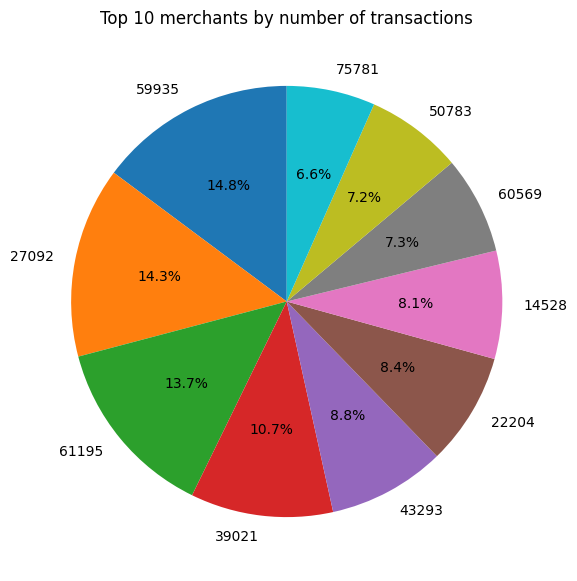

In [25]:
# Count transactions per merchant
top_merchants_count = (merged_df["merchant_id"].value_counts().head(10))

# Pie chart
plt.figure(figsize=(7,7))
top_merchants_count.plot(kind="pie", autopct='%1.1f%%', startangle=90)
plt.title("Top 10 merchants by number of transactions")
plt.ylabel("")  # remove y-label
plt.show()


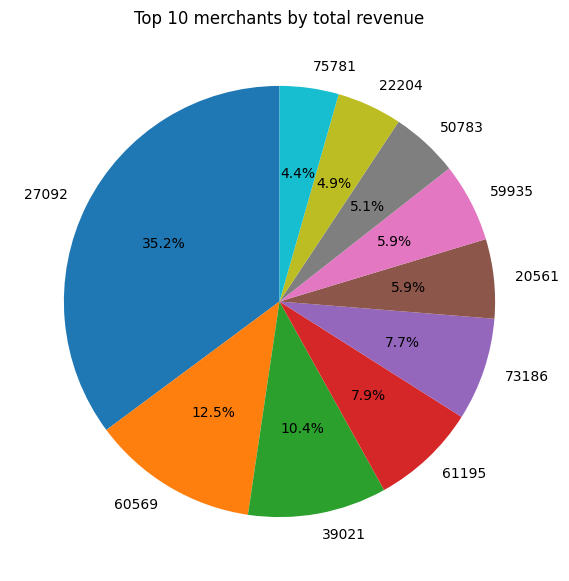

In [26]:
# Total revenue per merchant
top_merchants_revenue = (merged_df.groupby("merchant_id")["amount"].sum().sort_values(ascending=False).head(10))

# Pie chart
plt.figure(figsize=(7,7))
top_merchants_revenue.plot(kind="pie", autopct='%1.1f%%', startangle=90)
plt.title("Top 10 merchants by total revenue")
plt.ylabel("")
plt.show()

**Interpretation**

The number of transactions among the top 10 merchants is fairly even (6.6%–14.8%), but revenue varies greatly (4.4%–35.2%). This suggests some merchants sell high-value items, likely luxury goods or large orders, where fewer transactions generate much higher revenue.

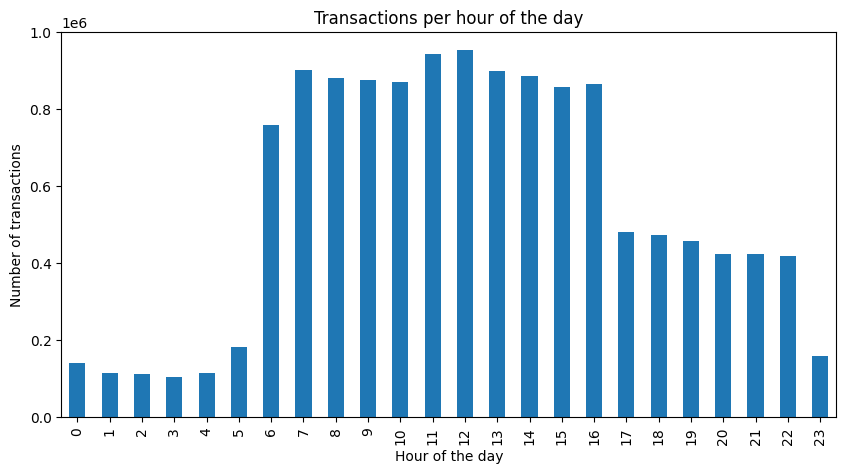

In [27]:
# Transactions per hour
txns_per_hour = merged_df["transaction_hour"].value_counts().sort_index()

plt.figure(figsize=(10,5))
txns_per_hour.plot(kind="bar")
plt.title("Transactions per hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("Number of transactions")
plt.show()

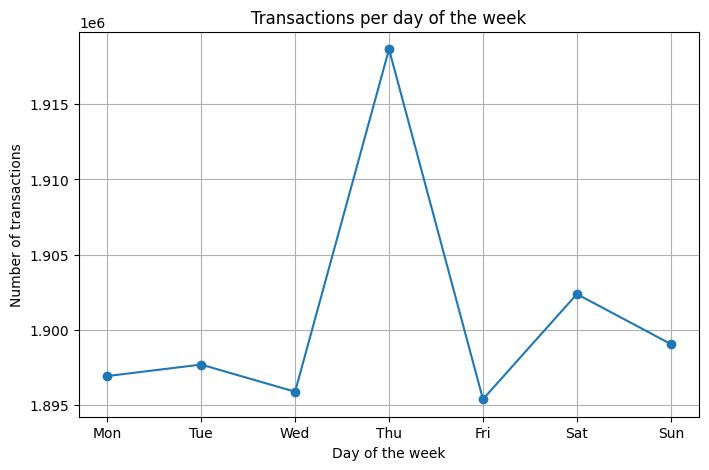

In [28]:
# Transactions per day of the week
txns_per_day = merged_df["transaction_day"].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.plot(txns_per_day.index, txns_per_day.values, marker="o")
plt.xticks(txns_per_day.index, ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.title("Transactions per day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Number of transactions")
plt.grid(True)
plt.show()

**Interpretations**

Transactions peak between 6h and 16h, with a smaller drop in the evening, indicating most activity occurs during business hours.


By day of the week, transaction volumes are fairly stable from Monday to Wednesday, peak on Thursday, dip slightly on Friday, rise again on Saturday, and drop on Sunday (though still above the slowest days).

## 6. Encodage des variables catégorielles
  - Codes MCC, types de cartes  
  - Méthodes d’encodage testées (Label vs One-hot)  
  - Justification des choix retenus 

**1. Label Encoding**

In [29]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

use_chip_le = pd.Series(label_encoder.fit_transform(merged_df["use_chip"]), name="use_chip_encoded")
use_chip_le

0           2
1           2
2           2
3           2
4           2
           ..
13305910    0
13305911    0
13305912    0
13305913    0
13305914    0
Name: use_chip_encoded, Length: 13305915, dtype: int64

In [30]:
mcc_code_le = pd.Series(label_encoder.fit_transform(merged_df["mcc_code"]), name="mcc_code_le")
mcc_code_le

0           78
1           69
2           70
3           50
4           57
            ..
13305910    56
13305911    85
13305912    56
13305913    56
13305914    53
Name: mcc_code_le, Length: 13305915, dtype: int64

**2. One-Hot Encoding**

In [31]:
use_chip_onehot = pd.get_dummies(merged_df["use_chip"], prefix="use_chip", drop_first=True)
use_chip_onehot

,use_chip_Online Transaction,use_chip_Swipe Transaction
1795,False,True
2960,False,True
3299,False,True
4955,False,True
8801,False,True
...,...,...
13296767,False,False
13301863,False,False
13302035,False,False
13302463,False,False


In [32]:
mcc_code_onehot = pd.get_dummies(merged_df["mcc_code"], prefix="mcc_code", drop_first=True)
mcc_code_onehot

,mcc_code_3000,mcc_code_3001,mcc_code_3005,mcc_code_3006,mcc_code_3007,mcc_code_3008,mcc_code_3009,mcc_code_3058,mcc_code_3066,mcc_code_3075,...,mcc_code_8011,mcc_code_8021,mcc_code_8041,mcc_code_8043,mcc_code_8049,mcc_code_8062,mcc_code_8099,mcc_code_8111,mcc_code_8931,mcc_code_9402
1795,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2960,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3299,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4955,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8801,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13296767,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13301863,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13302035,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13302463,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Answer**
For `mcc_code` (which has many categories), label encoding is more practical to avoid generating too many columns.
For `use_chip` (which has only a few categories), one-hot encoding is more appropriate.

# 3.2  Analyse d’association (20%)


In [33]:
merged_df.head()

,date,client_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,card_brand,...,credit_score,num_credit_cards,mcc_code,mcc_description,is_fraud,transaction_hour,transaction_day,transaction_month,amount_to_income,time_since_last_txn
1795,2010-01-01 13:10:00,0,33.96,Swipe Transaction,20519,Portland,ME,4101.0,5942,Mastercard,...,763,4,5942,Book Stores,No,13,4,1,0.000570,NaN
2960,2010-01-01 19:39:00,0,7.78,Swipe Transaction,55060,Scarborough,ME,4074.0,5812,Mastercard,...,763,4,5812,Eating Places and Restaurants,No,19,4,1,0.000131,23340.0
3299,2010-01-01 22:13:00,0,65.86,Swipe Transaction,32164,Scarborough,ME,4074.0,5813,Mastercard,...,763,4,5813,Drinking Places (Alcoholic Beverages),No,22,4,1,0.001105,9240.0
4955,2010-01-02 13:08:00,0,55.85,Swipe Transaction,26909,Standish,ME,4084.0,5211,Mastercard,...,763,4,5211,Lumber and Building Materials,NaN,13,5,1,0.000937,53700.0
8801,2010-01-03 15:44:00,0,1.37,Swipe Transaction,14528,Scarborough,ME,4074.0,5499,Mastercard,...,763,4,5499,Miscellaneous Food Stores,No,15,6,1,0.000023,95760.0


In [34]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt

- **1. Préparation des transactions pour Apriori / FP-Growth**  
  - Structure attendue   (apriori vs fp-growth)
 
    Les algorithmes attendent que chaque transaction soit représentée comme un ensemble d'items.
    
  - Préparation des transactions pour être compatibles avec chacune

 
    Les données doivent être transformées en format binaire (one-hot encoding) où chaque colonne correspond à la présence ou l'absence d'un item.
    

In [84]:
df_assoc = merged_df.copy()

SAMPLE_SIZE = 5000000 ## Pour permettre un temps d'exêcution raisonnable
if len(df_assoc) > SAMPLE_SIZE:
    df_assoc = df_assoc.sample(n=SAMPLE_SIZE, random_state=42)
    print(f"Utilisation d'un échantillon de {SAMPLE_SIZE} transactions")

# 1. Catégorisation du montant en quartiles
q1, q2, q3 = df_assoc["amount"].quantile([0.25, 0.50, 0.75])
def categorize_amount(x):
    if x <= q1:
        return "amount_low"
    elif x <= q2:
        return "amount_medium"
    elif x <= q3:
        return "amount_high"
    else:
        return "amount_very_high"
df_assoc["amount_item"] = df_assoc["amount"].apply(categorize_amount)

# 2. Catégorisation du score de crédit
def categorize_credit(x):
    if x < 500:
        return "credit_low"
    elif x < 700:
        return "credit_medium"
    else:
        return "credit_high"
df_assoc["credit_score_item"] = df_assoc["credit_score"].apply(categorize_credit)

# 3. Catégorisation du nombre de cartes de crédit
def categorize_num_cards(x):
    if x == 1:
        return "one_card"
    elif x == 2:
        return "two_cards"
    elif x <= 4:
        return "three_four_cards"
    else:
        return "five_plus_cards"
df_assoc["num_cards_item"] = df_assoc["num_credit_cards"].apply(categorize_num_cards)

# 4. Catégorisation de l'heure de transaction
def categorize_hour(x):
    if 0 <= x < 6:
        return "hour_night"
    elif 6 <= x < 12:
        return "hour_morning"
    elif 12 <= x < 18:
        return "hour_afternoon"
    else:
        return "hour_evening"
df_assoc["hour_item"] = df_assoc["transaction_hour"].apply(categorize_hour)

# 5. Catégorisation du jour de la semaine
day_map = {
    0: "day_monday", 1: "day_tuesday", 2: "day_wednesday", 
    3: "day_thursday", 4: "day_friday", 5: "day_saturday", 6: "day_sunday"
}
df_assoc["day_item"] = df_assoc["transaction_day"].map(day_map)

# 6. Catégorisation du mois
month_map = {
    1: "month_jan", 2: "month_feb", 3: "month_mar", 4: "month_apr",
    5: "month_may", 6: "month_jun", 7: "month_jul", 8: "month_aug",
    9: "month_sep", 10: "month_oct", 11: "month_nov", 12: "month_dec"
}
df_assoc["month_item"] = df_assoc["transaction_month"].map(month_map)

# 7. Catégorisation du temps depuis dernière transaction
if 'time_since_last_txn' in df_assoc.columns:
    def categorize_time_since_last(x):
        if pd.isna(x):
            return "first_transaction"
        elif x <= 3600:  # 1 heure
            return "time_since_short"
        elif x <= 86400:  # 1 jour
            return "time_since_medium"
        else:
            return "time_since_long"
    df_assoc["time_since_item"] = df_assoc["time_since_last_txn"].apply(categorize_time_since_last)

# 8. Catégorisation du ratio amount_to_income
if 'amount_to_income' in df_assoc.columns:
    q1_ratio, q2_ratio, q3_ratio = df_assoc["amount_to_income"].quantile([0.25, 0.50, 0.75])
    def categorize_ratio(x):
        if x <= q1_ratio:
            return "ratio_low"
        elif x <= q2_ratio:
            return "ratio_medium"
        elif x <= q3_ratio:
            return "ratio_high"
        else:
            return "ratio_very_high"
    df_assoc["ratio_item"] = df_assoc["amount_to_income"].apply(categorize_ratio)

# 9. Transformation des colonnes qualitatives existantes
df_assoc["card_type_item"] = df_assoc["card_type"].astype(str).str.lower().apply(lambda x: "card_" + x)
df_assoc["merchant_state_item"] = df_assoc["merchant_state"].astype(str).apply(lambda x: "state_" + x)
df_assoc["mcc_code_item"] = label_encoder.fit_transform(df_assoc["mcc_code"])
df_assoc["mcc_code_item"] = "mcc_" + df_assoc["mcc_code"].astype(str)
df_assoc["mcc_description_item"] = df_assoc["mcc_description"].astype(str).str.lower().apply(lambda x: "mcc_" + x.replace(" ", "_"))
df_assoc["fraud_item"] = df_assoc["is_fraud"].apply(lambda x: "fraud_yes" if x == "Yes" else "fraud_no")

# 10. Transformation de use_chip (méthode de paiement)
df_assoc["chip_item"] = df_assoc["use_chip"].astype(str).str.lower().apply(lambda x: "chip_" + x.replace(" ", "_"))

# Liste complète des colonnes à considérer pour l'analyse associative
cols_items = [
    "amount_item", "credit_score_item", "num_cards_item", 
    "hour_item", "day_item", "month_item",
    "card_type_item", "merchant_state_item", "mcc_code_item", "mcc_description_item", 
    "fraud_item", "chip_item"
]

# Ajout des colonnes conditionnelles
if 'time_since_item' in df_assoc.columns:
    cols_items.append("time_since_item")
if 'ratio_item' in df_assoc.columns:
    cols_items.append("ratio_item")

# Création du format transactionnel - UNE transaction par ligne
transactions = df_assoc[cols_items].apply(lambda x: x.values.tolist(), axis=1)
transactions = transactions.reset_index()
transactions.columns = ['transaction_id', 'items']

# Affichage du résultat
print(f"Nombre de transactions : {len(transactions)}")
print(f"Colonnes utilisées : {cols_items}")
print(f"Nombre d'items par transaction : {len(transactions.iloc[0]['items'])}")

# Afficher une transaction complète
print("\nPremière transaction complète:")
for i, item in enumerate(transactions.iloc[0]['items'], 1):
    print(f"  {i:2d}. {item}")
    
transactions.head()

Utilisation d'un échantillon de 5000000 transactions
Nombre de transactions : 5000000
Colonnes utilisées : ['amount_item', 'credit_score_item', 'num_cards_item', 'hour_item', 'day_item', 'month_item', 'card_type_item', 'merchant_state_item', 'mcc_code_item', 'mcc_description_item', 'fraud_item', 'chip_item', 'time_since_item', 'ratio_item']
Nombre d'items par transaction : 14

Première transaction complète:
   1. amount_high
   2. credit_medium
   3. two_cards
   4. hour_morning
   5. day_sunday
   6. month_aug
   7. card_debit
   8. state_IL
   9. mcc_7230
  10. mcc_beauty_and_barber_shops
  11. fraud_no
  12. chip_chip_transaction
  13. time_since_medium
  14. ratio_very_high


,transaction_id,items
0,12995278,"[amount_high, credit_medium, two_cards, hour_m..."
1,7630452,"[amount_high, credit_high, five_plus_cards, ho..."
2,298526,"[amount_high, credit_low, five_plus_cards, hou..."
3,11279918,"[amount_low, credit_medium, five_plus_cards, h..."
4,4003883,"[amount_low, credit_high, five_plus_cards, hou..."


- **2.Extraction de règles d’association**  
  - Exemples concrets  
  - Patterns observés (habitudes de consommation, fidélité, etc.)

In [85]:
# 2. Extraction de règles d’association
print("=" * 60)
print("2. EXTRACTION DE RÈGLES D'ASSOCIATION")
print("=" * 60)

from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import matplotlib.pyplot as plt
import seaborn as sns

# Préparation des données pour Apriori/FP-Growth
te = TransactionEncoder()
te_ary = te.fit(transactions['items']).transform(transactions['items'])
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Shape du dataset encodé: {df_encoded.shape}")
print(f"Nombre de transactions: {len(df_encoded)}")
print(f"Nombre d'items uniques: {len(df_encoded.columns)}")

# Calcul des itemsets fréquents
frequent_itemsets_apriori = apriori(df_encoded, min_support=0.4, use_colnames=True)
frequent_itemsets_apriori['length'] = frequent_itemsets_apriori['itemsets'].apply(lambda x: len(x))

print(f"\nNombre d'itemsets fréquents trouvés: {len(frequent_itemsets)}")
print(f"Support moyen: {frequent_itemsets_apriori['support'].mean():.4f}")

# Extraction des règles d'association
apriori_rules = association_rules(frequent_itemsets_apriori, metric="lift", min_threshold=0.5)

apriori_rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False)



2. EXTRACTION DE RÈGLES D'ASSOCIATION
Shape du dataset encodé: (5000000, 462)
Nombre de transactions: 5000000
Nombre d'items uniques: 462

Nombre d'itemsets fréquents trouvés: 15
Support moyen: 0.5653


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
13,(time_since_medium),(fraud_no),0.657880,0.999015,0.657359,0.999207,1.000193,1.0,0.000127,1.242607,0.000563,0.657664,0.195240,0.828607
12,(fraud_no),(time_since_medium),0.999015,0.657880,0.657359,0.658007,1.000193,1.0,0.000127,1.000370,0.195395,0.657664,0.000370,0.828607
1,(card_debit),(fraud_no),0.622432,0.999015,0.621874,0.999104,1.000089,1.0,0.000055,1.098961,0.000235,0.622140,0.090050,0.810795
0,(fraud_no),(card_debit),0.999015,0.622432,0.621874,0.622487,1.000089,1.0,0.000055,1.000146,0.090130,0.622140,0.000146,0.810795
7,(credit_high),(fraud_no),0.621441,0.999015,0.620808,0.998981,0.999966,1.0,-0.000021,0.966904,-0.000089,0.621026,-0.034229,0.810201
6,(fraud_no),(credit_high),0.999015,0.621441,0.620808,0.621420,0.999966,1.0,-0.000021,0.999945,-0.033129,0.621026,-0.000055,0.810201
4,(chip_swipe_transaction),(fraud_no),0.523909,0.999015,0.523809,0.999810,1.000795,1.0,0.000416,5.171895,0.001670,0.524273,0.806647,0.762068
5,(fraud_no),(chip_swipe_transaction),0.999015,0.523909,0.523809,0.524326,1.000795,1.0,0.000416,1.000876,0.806801,0.524273,0.000875,0.762068
11,(three_four_cards),(fraud_no),0.495254,0.999015,0.494786,0.999055,1.000040,1.0,0.000020,1.042572,0.000080,0.495042,0.040834,0.747164
10,(fraud_no),(three_four_cards),0.999015,0.495254,0.494786,0.495274,1.000040,1.0,0.000020,1.000040,0.040873,0.495042,0.000040,0.747164


In [86]:
frequent_itemsets_fp_growth = fpgrowth(df_encoded, min_support=0.4, use_colnames=True)
frequent_itemsets_fp_growth

,support,itemsets
0,0.999015,(fraud_no)
1,0.657880,(time_since_medium)
2,0.622432,(card_debit)
3,0.621441,(credit_high)
4,0.523909,(chip_swipe_transaction)
5,0.495254,(three_four_cards)
6,0.657359,"(fraud_no, time_since_medium)"
7,0.621874,"(fraud_no, card_debit)"
8,0.408927,"(card_debit, time_since_medium)"
9,0.408635,"(fraud_no, card_debit, time_since_medium)"


In [87]:
regles = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
print("\nrègle d'association:")
for _, row in regles.iterrows():
    print(f"{set(row['antecedents'])} → {set(row['consequents'])} | "
          f"support: {row['support']:.2f}, confiance: {row['confidence']:.2f}, lift: {row['lift']:.2f}")


règle d'association:
{'card_debit'} → {'fraud_no'} | support: 0.62, confiance: 1.00, lift: 1.00
{'chip_swipe_transaction'} → {'fraud_no'} | support: 0.52, confiance: 1.00, lift: 1.00
{'credit_high'} → {'fraud_no'} | support: 0.62, confiance: 1.00, lift: 1.00
{'three_four_cards'} → {'fraud_no'} | support: 0.49, confiance: 1.00, lift: 1.00
{'time_since_medium'} → {'fraud_no'} | support: 0.66, confiance: 1.00, lift: 1.00
{'card_debit', 'time_since_medium'} → {'fraud_no'} | support: 0.41, confiance: 1.00, lift: 1.00
{'time_since_medium', 'credit_high'} → {'fraud_no'} | support: 0.41, confiance: 1.00, lift: 1.00


In [88]:
multi_antecedent_rules = apriori_rules[apriori_rules['antecedents'].apply(lambda x: len(x) >= 2)]
multi_antecedent_rules.sort_values(["support", "confidence","lift"],axis = 0, 
                                                  ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
22,"(credit_high, time_since_medium)",(fraud_no),0.411733,0.999015,0.411393,0.999175,1.000160,1.0,0.000066,1.193759,0.000272,0.411659,0.162310,0.705487
21,"(fraud_no, credit_high)",(time_since_medium),0.620808,0.657880,0.411393,0.662674,1.007286,1.0,0.002976,1.014211,0.019077,0.474341,0.014012,0.644003
20,"(fraud_no, time_since_medium)",(credit_high),0.657359,0.621441,0.411393,0.625827,1.007059,1.0,0.002883,1.011723,0.020456,0.474280,0.011587,0.643913
16,"(card_debit, time_since_medium)",(fraud_no),0.408927,0.999015,0.408635,0.999285,1.000271,1.0,0.000111,1.378764,0.000458,0.408918,0.274713,0.704162
14,"(fraud_no, card_debit)",(time_since_medium),0.621874,0.657880,0.408635,0.657102,0.998817,1.0,-0.000484,0.997730,-0.003123,0.469091,-0.002275,0.639120
15,"(fraud_no, time_since_medium)",(card_debit),0.657359,0.622432,0.408635,0.621631,0.998713,1.0,-0.000526,0.997883,-0.003746,0.469072,-0.002121,0.639072


In [89]:
multi_consequent_rules = apriori_rules[apriori_rules['consequents'].apply(lambda x: len(x) >= 2)]
multi_consequent_rules.sort_values(["support", "confidence","lift"],axis = 0, 
                                                  ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
25,(credit_high),"(fraud_no, time_since_medium)",0.621441,0.657359,0.411393,0.661999,1.007059,1.0,0.002883,1.013728,0.018515,0.474280,0.013542,0.643913
24,(time_since_medium),"(fraud_no, credit_high)",0.657880,0.620808,0.411393,0.625331,1.007286,1.0,0.002976,1.012073,0.021144,0.474341,0.011929,0.644003
23,(fraud_no),"(credit_high, time_since_medium)",0.999015,0.411733,0.411393,0.411799,1.000160,1.0,0.000066,1.000112,0.162444,0.411659,0.000112,0.705487
18,(card_debit),"(fraud_no, time_since_medium)",0.622432,0.657359,0.408635,0.656513,0.998713,1.0,-0.000526,0.997537,-0.003401,0.469072,-0.002469,0.639072
19,(time_since_medium),"(fraud_no, card_debit)",0.657880,0.621874,0.408635,0.621138,0.998817,1.0,-0.000484,0.998058,-0.003450,0.469091,-0.001946,0.639120
17,(fraud_no),"(card_debit, time_since_medium)",0.999015,0.408927,0.408635,0.409038,1.000271,1.0,0.000111,1.000187,0.274909,0.408918,0.000187,0.704162


- **3. Codes MCC et types de commerces**  
  - Dépenses élevées  
  - Patterns comportementaux  


In [93]:
# 3. Codes MCC et types de commerces
# Filtrer seulement les transactions avec montants élevés
high_amount_transactions = df_assoc[df_assoc["amount_item"].isin(["amount_high", "amount_very_high"])]

# Analyser la distribution des MCC pour les montants élevés
print("Top MCC pour les dépenses élevées:")

mcc_high_amount = (
    high_amount_transactions
    .groupby(["mcc_code_item", "mcc_description_item"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(5)
)

print(mcc_high_amount)

Top MCC pour les dépenses élevées:
   mcc_code_item           mcc_description_item   count
59      mcc_5541           mcc_service_stations  238845
43      mcc_4829             mcc_money_transfer  207412
57      mcc_5499  mcc_miscellaneous_food_stores  192208
41      mcc_4784      mcc_tolls_and_bridge_fees  161922
53      mcc_5300            mcc_wholesale_clubs  159860


**Interprétation**  

L’analyse des codes MCC associés aux transactions élevées révèle que les dépenses importantes se concentrent principalement sur des postes essentiels (carburant, alimentation en gros), des transferts d’argent et des frais liés à la mobilité. Ces résultats mettent en évidence des comportements de consommation réguliers mais aussi des usages financiers spécifiques qui pourraient être pertinents pour la détection de fraude ou l’étude des habitudes clients.


- **4. Associations types cartes ↔ commerçants**  
  - Profils d’utilisation  

- **5.Combinaisons liées aux fraudes**  
  - Montants élevés, heures tardives, types de commerçants


- **6. interprétation des métriques**  
  - Support, confiance, lift  
  - Visualisations des règles  

- **7. Choix des seuils (support, confiance)**  
  - Justification en fonction du volume et de l’objectif  

# 3.3 Analyse de séquences (15%)

- **Construction des séquences de transactions**  
  - Par client  
  - Variables d’ordre  (horodatage, type de commer¸cant, montant, etc.)?

- **Application d’algorithmes (PrefixSpan, SPADE, EMMA)**  
  - Parcours typiques identifiés  


- **Habitudes et routines**  
  - Parcours d’achat récurrents  (fréquences, routines ou habitudes récurrentes)


- **Patterns précurseurs de fraude**  
  - Petites transactions → retrait → fraude  
  - Interprétation  par motifs temporels ou comportementaux


- **Évolution du comportement client**  
  - Séquences avec contraintes temporelles 


- **Visualisations**  
  - Graphes de séquences fréquentes  
  - Aide à l’interprétation  

# 3.4 Recommandation sur les associations ou séquences (10%)

- **Objectif : proposer des items complémentaires**  
- **Méthodes testées :**  
  - Règles d’association fréquentes  
  - Séquences typiques  
  - Similarité entre transactions  
- **Implémentation d’un script Python autonome (`recommender.py`)**  
- **Exemple de recommandations générées**  

---

# 3.5 Analyse statistique comparative des classes (10%)

- **Comparaison fraude vs légitime**  
  - Scatter plots (2D, 3D)  
  - Réduction de dimension (ACP, t-SNE, UMAP)  
  - Regroupements et anomalies  


- **Approche univariée**  
  - Sélection de variables pertinentes  
  - Tests statistiques (t-test, Mann-Whitney, KS-test)  
  - Résultats comparés  


- **Approche multivariée**  
  - Hotelling, analyse discriminante linéaire  
  - Séparation des classes  
  - Visualisations complémentaires 

- **Discussion**  
  - Avantages, limites et implications  
  - Robustesse et pertinence des méthodes  

---

# 3.6 Pr´esentation des r´esultats (20%)


- Objectif de chaque méthode (bref rappel)  
- Démarche appliquée  
- Résultats obtenus  
- Commentaires et interprétations  
- Visualisations pertinentes  
- Citations des sources utilisées (obligatoires)  